#**Evaluating & Improving ML models**

---

Case Study: Titanic Survival

**Objective:** The objective of this notebook is to walk you through several concepts that we discussed through the course for evaluating and improving ML models. You will be building and evaluating several models that will predict if a person survived or not during the Titanic incidence.

The titanic.csv file contains data for 891 of the original Titanic passengers. Each row represents one person. The columns describe different attributes about the person including:
* whether they survived (S),
* their age (A),
* their passenger-class (C),
* their gender (G),
* the fare they paid (X).

##**Section 1: Evaluating ML models**

In this first section, we will be building and evaluating ML models.

### **Importing Needed Libraries:**

* numpy: for scientific computing
* matplot: for plotting and visualization
* pandas: for data reading and manipulation
* sklearn.svm for Support Vector Machine Implementation




In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### **Importing the Data**
The data is stored on the drive in a CSV file

In [4]:
data = pd.read_csv('/content/titanic.csv') # Read the Data from the Drive

df = pd.DataFrame(data, columns= ['Survived', 'Pclass', 'Name', 'Age', 'Sex', 'Fare']) # Gets the specific data we need for our prediction
df.replace(('male', 'female'), (0, 1), inplace=True) # Male is 0, Female is 1
df.head() # Prints the first 5 rows of the data

<ipython-input-4-15ac91826cc3>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(('male', 'female'), (0, 1), inplace=True) # Male is 0, Female is 1


,Survived,Pclass,Name,Age,Sex,Fare
0,0,3,"Braund, Mr. Owen Harris",22.0,0,7.2500
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,71.2833
2,1,3,"Heikkinen, Miss. Laina",26.0,1,7.9250
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,53.1000
4,0,3,"Allen, Mr. William Henry",35.0,0,8.0500


In [5]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Know the shape of the data

In [6]:
df.shape

(891, 6)

### **Data Preprocessing:**


Check for null values

In [7]:
print(df.isnull().sum())

Survived      0
Pclass        0
Name          0
Age         177
Sex           0
Fare          0
dtype: int64


Filling the null values

In [8]:
df['Age'].fillna(value = df['Age'].mean(), inplace=True)

<ipython-input-8-8a49dd03d04c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(value = df['Age'].mean(), inplace=True)


In [9]:
print(df.isnull().sum()) # Make sure all nulls are removed

Survived    0
Pclass      0
Name        0
Age         0
Sex         0
Fare        0
dtype: int64


Data preprocessing involves dividing the data into attributes and labels.

In [10]:
x = df.drop(['Survived', 'Name'], axis = 1) # All the columns except the Name of the person and the target columns are
                                            # being removed from the features data
y = df['Survived']

### **K-fold Cross Validation on SVMs:**
We will be implementing k-Fold CV from scratch on a Linear and a Gaussian SVM on the dataset shown above.

To do so, we will be dividing the process in two parts, as seen in the figure below.
First, we'll define the function below to split the data to k-folds.

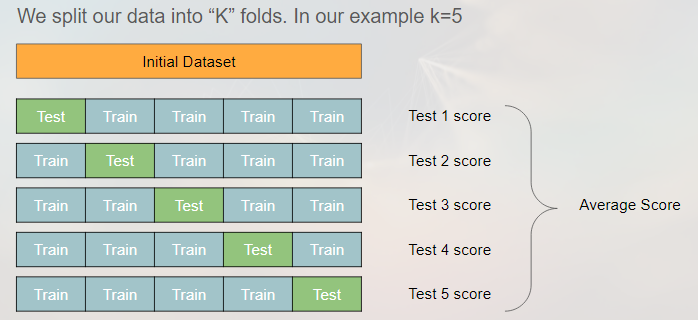






In [11]:
from random import randrange

def cross_validation_split(dataset, folds):
        dataset_split = [] # Create empty list to store the different splits
        dataset_copy = pd.DataFrame.copy(dataset) # Create a copy of the data
        fold_size = int(len(dataset) / folds) # No of samples in each fold

        # 'for' loop to store each fold in the dataset_split list we created
        for i in range(folds):
            fold = []

            # 'while' loop to add data samples to the folds
            while len(fold) < fold_size:
              index = randrange(len(dataset_copy)) # Creating indicies to randomly select fold_size # of samples in each fold
              fold.append(dataset_copy.loc[index]) # Capturing the indicies from original dataset using .loc function
              dataset_copy.drop(labels=index, axis=0) # Removing the samples we captured so we do not add replicates of them in another fold

            # Save the fold
            dataset_split.append(fold)

        return dataset_split, fold_size

The following second part of the process will take each fold as a test split and return the accuracies for each for both the linear and the Gaussian kernel SVM:

In [12]:
def kfoldCV(dataset, k=5, model="linear"):
    result=[]

    splits, fold_size = cross_validation_split(dataset,k) #calling our previous function

    # 'for' loop that trains and evaluates each SVM model on one of the test folds, saving performance in 'result' list
    for j in range(k) :

      train = splits[:j] + splits[j+1:] # Selecting splits before and after index j (which we'll use as a test split)
      test = splits[j]

      # Train is a list of folds, we need to change it to a list containing all training examples so we can feed it to sklearn's model
      train = [example  for fold in train  for example in fold] # Where example is a data sample/instance

      data_train = pd.DataFrame(train, columns = ['Survived', 'Pclass', 'Name', 'Age', 'Sex', 'Fare'])
      data_test = pd.DataFrame(test, columns = ['Survived', 'Pclass', 'Name', 'Age', 'Sex', 'Fare'])

      x_train = data_train.drop(['Survived', 'Name'], axis = 1)
      y_train = data_train['Survived']
      x_test = data_test.drop(['Survived', 'Name'], axis = 1)
      y_test = data_test['Survived']

      # Apply the selected model
      # Default is linear
      if model == "linear": # Train and store accuracies of each fold for a linear SVM
        svclassifier = SVC(kernel = 'linear')
        svclassifier.fit(x_train, y_train)
        y_pred = svclassifier.predict(x_test)
        result.append(accuracy_score(y_pred, y_test))

      elif model == "kernel": # Train and store accuracies of each fold for a kernel SVM
        svclassifier = SVC(kernel='rbf')
        svclassifier.fit(x_train, y_train)
        y_pred = svclassifier.predict(x_test)
        result.append(accuracy_score(y_pred, y_test))

    return result, fold_size

### **Evaluation of the 2 Models**
Now that we defined the functions needed to apply the k-fold CV, we will be applying them on the dataset.


For that, we will be using a 5-fold cross validation:

In [13]:
Lin_Accs, fold_size = kfoldCV(df,k=5,model = 'linear')
Ker_Accs, fold_size = kfoldCV(df,k=5,model = 'kernel')

In [14]:
print("Linear:")
print(Lin_Accs)
print("The average accuracy for the Linear SVM is", sum(Lin_Accs)/len(Lin_Accs))

print("Kernel:")
print(Ker_Accs)
print("The average accuracy for the Kernel SVM is", sum(Ker_Accs)/len(Ker_Accs))

Linear:
[0.797752808988764, 0.797752808988764, 0.8314606741573034, 0.7808988764044944, 0.7752808988764045]
The average accuracy for the Linear SVM is 0.796629213483146
Kernel:
[0.6797752808988764, 0.6910112359550562, 0.6853932584269663, 0.6573033707865169, 0.6573033707865169]
The average accuracy for the Kernel SVM is 0.6741573033707865


We can see from the results above that the average accuracy of the Linear SVM is higher than the kernel SVM according to the k-fold CV.

## **Section 2: Comparing ML Models**

Now we will be working on comparing our models using statistical tests.

### **Test For Difference in Proportion**
We will be using the z-score test to see if there is a statistical difference between the models. We start by setting the Hypothesis:
* Null Hypothesis H0: The two models perform the same
* Alternate Hypothesis H1: The two models do not perform the same






With a threshold alfa = 5%, we have a  z alpha/2 = 1.96 according to the z-table shown below:


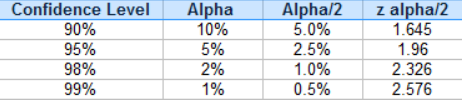



To calculate the value of z and the variances of the 2 models, we use the formulas below.

<img src="https://equatio-api.texthelp.com/svg/%5Csigma%5E2%3D%5Cfrac%7BAcc%5Ccdot%5Cleft(1-Acc%5Cright)%7D%7Bn%7D" alt="sigma squared equals the fraction with numerator A c c times open paren 1 minus A c c close paren and denominator n">
<br><img src="https://equatio-api.texthelp.com/svg/Z%5C%20%3D%5C%20%5Cfrac%7B%5Cleft(Acc_1-Acc_2%5Cright)%7D%7B%5Csqrt%7B%5Csigma_1%5E2%2B%5Csigma_2%5E2%7D%7D" alt="Z equals the fraction with numerator open paren A c c sub 1 minus A c c sub 2 close paren and denominator the square root of sigma sub 1 squared plus sigma sub 2 squared">

In [15]:
# Compute average accuracies of each model
acc1 = sum(Lin_Accs)/len(Lin_Accs)
acc2 = sum(Ker_Accs)/len(Ker_Accs)

# Compute variances of each model
var1 = acc1*(1-acc1)/fold_size # Fold size is the number of examples in the test set
var2 = acc2*(1-acc2)/fold_size

# Compute z-score
z = (acc1 - acc2)/np.sqrt(var1 + var2)
print(z)

z_alpha_over_2 = 1.96 # This value is for a 95% confidence level

if abs(z) < z_alpha_over_2:
  print('The z value is smaller than the Z threshold, which means we DO NOT reject the null hypothesis.')
else:
  print('The z value is greater than the Z threshold, which means we REJECT the null hypothesis. The linear model is indeed better than the non-linear model.')

2.6448228924570647
The z value is greater than the Z threshold, which means we REJECT the null hypothesis. The linear model is indeed better than the non-linear model.


## **Section 3: Improving ML Models**

Now we will explore some techniques that will help us to improve the performance of our ML models.

###**Checking for Imbalanced Data**

In [ ]:
df['Survived'].hist()

Let's say we want to fit on this imbalanced dataset a Logistic Regression model.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
scores = cross_validate(model, x, y, cv=3, scoring=['accuracy','precision', 'recall', 'f1_macro'])

accuracy_1 = scores.get('test_accuracy').mean()
precision_1 = scores.get('test_precision').mean()
recall_1 = scores.get('test_recall').mean()
f1_1 = scores.get('test_f1_macro').mean()

print("Accuracy:", accuracy_1,
      "\nPrecision:",precision_1,
      "\nRecall:", recall_1,
      "\nF1 Score:", f1_1)

Let's try to oversample our minority class (Survived) and train the model again:

In [ ]:
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler(sampling_strategy= 1) # sampling_strategy = 1 means we want both classes to have equal number of samples
x_new, y_new = over.fit_resample(x, y)

Check the performance of our model after we have a balanced dataset:

In [ ]:
from sklearn.model_selection import cross_validate

model = LogisticRegression()
scores = cross_validate(model, x_new, y_new, cv=3, scoring=['accuracy','precision', 'recall', 'f1_macro'])

accuracy_2 = scores.get('test_accuracy').mean()
precision_2 = scores.get('test_precision').mean()
recall_2 = scores.get('test_recall').mean()
f1_2 = scores.get('test_f1_macro').mean()

print("Accuracy:", accuracy_2,
      "\nPrecision:",precision_2,
      "\nRecall:", recall_2,
      "\nF1 Score:", f1_2)

We can see the improved effect of balancing the data on the precision, recall, and f1-score terms!!

### **Random Forest Classifier**

Let's try to improve our model a bit by using an ensemble method - the Decision/Random Forest.

A Decision Forest (or Random Forest) is an ensemble method relying on the aggregate predictions of several trees instead of one tree only. It belongs to the class of bagging ensemble methods.  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 100) # 100 trees participating in the aggregate prediction
scores = cross_validate(model, x_new, y_new, cv=3, scoring=['accuracy','precision', 'recall', 'f1_macro'])

accuracy_3 = scores.get('test_accuracy').mean()
precision_3 = scores.get('test_precision').mean()
recall_3 = scores.get('test_recall').mean()
f1_3 = scores.get('test_f1_macro').mean()

print("Accuracy:", accuracy_3,
      "\nPrecision:",precision_3,
      "\nRecall:", recall_3,
      "\nF1 Score:", f1_3)

After applying Random Forests to our balanced dataset, we can see an improvement in performance in both the precision and F1 scores!

Of course, there are many more improvements we can explore. It might also be useful to run more in depth EDA so we can choose the best & most effective improvement techniques for our problem and dataset.